## Importation des packages

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from functions import *
import scipy.stats as st
from collections import Counter
from datetime import datetime as dt 

##  Importation des données 

Les données de la world income distubition de 2008

In [2]:
data_WID = pd.DataFrame(pd.read_csv("data-projet7.csv", decimal=","))
data_WID.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


## Mission01

Les années des données utilisées: 2004, 2006, 2007, 2008, 2009, 2010 et 2011 \
Le nombre de pays: 116 \
Les quantiles de la distribution des revenus sont de type centile\
Échantillonner une population en utilisant des centiles c'est une bonne méthode car elle facilite l'analyse tel que elle permet de pouvoir comparer facilement entre les classes.\
chaque pays a 100 quantiles normalement on a 11600(116*100) mais nous avons que 11599 donc il manque un centile (qui est soit 41 soit 42).\
200 valeurs manquantes pour la vaiable gdppp.

In [3]:
from pandas_profiling import ProfileReport
profile  =  ProfileReport ( data_WID , title = "Rapport de la base de données" , explorative = True )
profile

Pour avoir une idée générale sur notre jeu de données

In [4]:
data_WID.describe(include="all")

,country,year_survey,quantile,nb_quantiles,income,gdpppp
count,11599,11599.000000,11599.000000,11599.0,11599.000000,1.139900e+04
unique,116,NaN,NaN,NaN,NaN,NaN
top,AUT,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.982757,50.500819,100.0,6069.224260,5.022128e+04
std,NaN,0.909633,28.868424,0.0,9414.185972,4.000688e+05
min,NaN,2004.000000,1.000000,100.0,16.719418,3.031931e+02
25%,NaN,2008.000000,25.500000,100.0,900.685515,2.576000e+03
50%,NaN,2008.000000,51.000000,100.0,2403.244900,7.560000e+03
75%,NaN,2008.000000,75.500000,100.0,7515.420900,1.877300e+04


On télécharge le fichier contenant le code et le nom des pays 

In [5]:
data_code = pd.read_csv("country-code-fr.csv", error_bad_lines=False)
data_code=data_code[['Pays','ISO3']]
data_code.rename(columns={'ISO3':'country'}, inplace=True)
data_code.head()

b'Skipping line 218: expected 4 fields, saw 5\nSkipping line 220: expected 4 fields, saw 5\n'


,Pays,country
0,Afghanistan,AFG
1,Îles Aland,ALA
2,Albanie,ALB
3,Algérie,DZA
4,Samoa américaines,ASM


On fait la jointure avec notre base de données

In [6]:
data_WID = pd.merge(data_WID, data_code,on='country', how='left')
data_WID.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays
0,ALB,2008,1,100,728.89795,7297.0,Albanie
1,ALB,2008,2,100,916.66235,7297.0,Albanie
2,ALB,2008,3,100,1010.91600,7297.0,Albanie
3,ALB,2008,4,100,1086.90780,7297.0,Albanie
4,ALB,2008,5,100,1132.69970,7297.0,Albanie


On vérifie les valeurs manquantes

In [7]:
data_WID.isnull().sum()

country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
Pays            800
dtype: int64

on détermine les pays concerné par les valeurs manquantes

In [8]:
data_WID[data_WID['Pays'].isnull()==True].country.unique()

array(['EST', 'HRV', 'XKX', 'LAO', 'NER', 'TWN', 'TZA', 'USA'],
      dtype=object)

On remplace les valeurs manquantes en utlilisant le wikipédia

In [9]:
data_WID.loc[data_WID['country']=="EST","Pays"]="Estonie"
data_WID.loc[data_WID['country']=="HRV","Pays"]="Croatie"
data_WID.loc[data_WID['country']=="XKX","Pays"]="Kosovo"
data_WID.loc[data_WID['country']=="LAO","Pays"]="Laos"
data_WID.loc[data_WID['country']=="NER","Pays"]="Niger"
data_WID.loc[data_WID['country']=="TWN","Pays"]="Taiwan"
data_WID.loc[data_WID['country']=="TZA","Pays"]="Tanzanie"
data_WID.loc[data_WID['country']=="USA","Pays"]="États-Unis"

On détermine les pays qui sont concernés par les valeurs manquantes pour la variable gdpppp

In [10]:
data_WID[data_WID['gdpppp'].isnull()==True].Pays.unique()


array(['Kosovo', 'Territoires palestiniens (occupés)'], dtype=object)

Les 2 pays 'XKX' et 'PSE' ont des valeurs manquantes (kosovo, LE territoire palestinien)

In [11]:
data_WID[(data_WID['country']=='XKX')|(data_WID['country']=='PSE')].groupby(['country','year_survey']).count()


,,quantile,nb_quantiles,income,gdpppp,Pays
country,year_survey,,,,,
PSE,2009,100,100,100,0,100
XKX,2008,100,100,100,0,100


On a des infos pour le kosovo en 2008 et pour LE territoire palestinien en 2009

On remplace les valeurs manquantes par des données disponible au site worldbank

In [12]:
data_WID.loc[data_WID['country']=="XKX","gdpppp"]=7249.357
data_WID.loc[data_WID['country']=="PSE","gdpppp"]=3951.235

On détecte le pays avec le centile manquant

In [13]:
d=data_WID.groupby('country').count()
d.loc[(d['nb_quantiles']<100),:]

,year_survey,quantile,nb_quantiles,income,gdpppp,Pays
country,,,,,,
LTU,99,99,99,99,99,99


Il manque le quantile 41 pour le pays Lituanie

In [14]:
data_WID[(data_WID['country']=='LTU')& ((data_WID['quantile']==41)|(data_WID['quantile']==42))]


,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays
6240,LTU,2008,42,100,4895.8306,17571.0,Lituanie


On calcule la moyenne des quantiles 40 et 42

In [15]:
qua42=data_WID[(data_WID['country']=='LTU')& (data_WID['quantile']==42)].income.sum()
qua40=data_WID[(data_WID['country']=='LTU')& (data_WID['quantile']==40)].income.sum()
qua41=(qua40+qua42)/2

On réinsére le quantile 41 pour le pays lituanie

In [16]:
data_WID=pd.DataFrame(np.insert(data_WID.values, 6240, values=['LTU',2008,41,100,qua41,17571.0,'Lituanie'], axis=0))
data_WID.rename(columns = { 0:'country', 1: 'year_survey',2:'quantile',3:'nb_quantiles',4:'income',5:'gdpppp',6:'Pays'}, inplace=True)

In [17]:
data_WID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11600 entries, 0 to 11599
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country       11600 non-null  object
 1   year_survey   11600 non-null  object
 2   quantile      11600 non-null  object
 3   nb_quantiles  11600 non-null  object
 4   income        11600 non-null  object
 5   gdpppp        11600 non-null  object
 6   Pays          11600 non-null  object
dtypes: object(7)
memory usage: 634.5+ KB


On vérifie qu'on a bien inséré la ligne 

In [18]:
data_WID[(data_WID['country']=='LTU')].head(50)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays
6200,LTU,2008,1,100,566.345,17571,Lituanie
6201,LTU,2008,2,100,1147.06,17571,Lituanie
6202,LTU,2008,3,100,1490.84,17571,Lituanie
6203,LTU,2008,4,100,1746.57,17571,Lituanie
6204,LTU,2008,5,100,1842.95,17571,Lituanie
6205,LTU,2008,6,100,1925.86,17571,Lituanie
6206,LTU,2008,7,100,2048.39,17571,Lituanie
6207,LTU,2008,8,100,2173.71,17571,Lituanie
6208,LTU,2008,9,100,2302.09,17571,Lituanie
6209,LTU,2008,10,100,2361.65,17571,Lituanie


On importe le fichier contenant la population à partir le site de worldbank 

In [19]:
population= pd.read_csv("pop3.csv", skiprows=4)
population.head(4)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,...,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,...,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0,NaN


On garde que les années utilisés dans notre étude 

In [20]:
population = population[['Country Code','2004','2006','2007', '2008','2009','2010','2011']]
population.rename(columns = {'Country Code' : 'country'}, inplace = True)

On transforme la dataframe

In [21]:
pp=population.melt(id_vars=['country'])
pp.rename(columns = {'variable' : 'year_survey'}, inplace = True)
pp.rename(columns = {'value' : 'population'}, inplace = True)
pp['year_survey']=pp['year_survey'].astype(int)
pp.head(4)

,country,year_survey,population
0,ABW,2004,98744.0
1,AFE,2004,441630149.0
2,AFG,2004,24726689.0
3,AFW,2004,297353098.0


On fait la jointure des deux dataframes 

In [22]:
df = data_WID.merge(pp,on=['country','year_survey'],how='left')
df

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,population
0,ALB,2008,1,100,728.898,7297,Albanie,2947314.0
1,ALB,2008,2,100,916.662,7297,Albanie,2947314.0
2,ALB,2008,3,100,1010.92,7297,Albanie,2947314.0
3,ALB,2008,4,100,1086.91,7297,Albanie,2947314.0
4,ALB,2008,5,100,1132.7,7297,Albanie,2947314.0
...,...,...,...,...,...,...,...,...
11595,COD,2008,96,100,810.623,303.193,Congo République démocratique du,60411195.0
11596,COD,2008,97,100,911.783,303.193,Congo République démocratique du,60411195.0
11597,COD,2008,98,100,1057.81,303.193,Congo République démocratique du,60411195.0
11598,COD,2008,99,100,1286.6,303.193,Congo République démocratique du,60411195.0


On vérifie les valeurs manquantes

In [23]:
df.isnull().sum()

country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp            0
Pays              0
population      100
dtype: int64

On détermine le pays 

In [24]:
df[df['population'].isnull()==True].country.unique()

array(['TWN'], dtype=object)

In [25]:
df[(df['country']=='TWN')]

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,population
10400,TWN,2008,1,100,3477.18,25342,Taiwan,NaN
10401,TWN,2008,2,100,4740.26,25342,Taiwan,NaN
10402,TWN,2008,3,100,5331.3,25342,Taiwan,NaN
10403,TWN,2008,4,100,5761.66,25342,Taiwan,NaN
10404,TWN,2008,5,100,6093.2,25342,Taiwan,NaN
...,...,...,...,...,...,...,...,...
10495,TWN,2008,96,100,38123.5,25342,Taiwan,NaN
10496,TWN,2008,97,100,41663.8,25342,Taiwan,NaN
10497,TWN,2008,98,100,46650.6,25342,Taiwan,NaN
10498,TWN,2008,99,100,54017,25342,Taiwan,NaN


On remplace les valeurs manquantes en utilisant le wikipédia

In [26]:
df.loc[df['country']=="TWN","population"]=23037000

On vérifie les valeurs manquantes

In [27]:
df.isnull().sum()

country         0
year_survey     0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
Pays            0
population      0
dtype: int64

On calcule la population couverte par l'étude

In [28]:
py=df.groupby(['Pays','year_survey']).mean()
py.reset_index(inplace=True)

In [29]:
#la population mondiale 
pop_mond = population[population['country']=="WLD"]
pop=np.transpose(pop_mond)
pop.reset_index(inplace=True)
pop = pop.iloc[1:]
pop.rename(columns = {'index' : 'year_survey'}, inplace = True)
pop.rename(columns = {259 : 'population_mond'}, inplace = True)
pop['year_survey']=pop['year_survey'].astype(int)

In [30]:
pyy = py.merge(pop,on=['year_survey'],how='right')
pyy['population_mond']=pyy['population']*100/pyy['population_mond']
print("le pourcentage de la population couverte par l'étude est:",pyy['population_mond'].sum(),'%')

le pourcentage de la population couverte par l'étude est: 91.97414218720594 %


Notre étude touche quasiment toute la population mondiale

On importe le fichier contenant les indices de gini à partir le site de worldbank 

In [31]:
gini1= pd.read_csv("gini2.csv", skiprows=4)
Gini = gini1[['Country Code','2004','2006','2007', '2008','2009','2010','2011']]
Gini.rename(columns = {'Country Code' : 'country'}, inplace = True)
Gini

C:\anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,country,2004,2006,2007,2008,2009,2010,2011
0,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AGO,NaN,NaN,NaN,42.7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
261,XKX,NaN,30.3,NaN,NaN,31.8,33.3,27.8
262,YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,ZAF,NaN,NaN,NaN,63.0,NaN,63.4,NaN
264,ZMB,54.3,54.6,NaN,NaN,NaN,55.6,NaN


On transforme la dataframe

In [32]:
ii=Gini.melt(id_vars=['country'])
ii.rename(columns = {'variable' : 'year_survey'}, inplace = True)
ii.rename(columns = {'value' : 'indice_gini'}, inplace = True)
ii['year_survey']=pp['year_survey'].astype(int)
ii

,country,year_survey,indice_gini
0,ABW,2004,NaN
1,AFE,2004,NaN
2,AFG,2004,NaN
3,AFW,2004,NaN
4,AGO,2004,NaN
...,...,...,...
1857,XKX,2011,27.8
1858,YEM,2011,NaN
1859,ZAF,2011,NaN
1860,ZMB,2011,NaN


On fait la jointure des deux dataframes 

In [33]:
df = df.merge(ii,on=['country','year_survey'],how='left')
df

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,population,indice_gini
0,ALB,2008,1,100,728.898,7297,Albanie,2947314.0,30.0
1,ALB,2008,2,100,916.662,7297,Albanie,2947314.0,30.0
2,ALB,2008,3,100,1010.92,7297,Albanie,2947314.0,30.0
3,ALB,2008,4,100,1086.91,7297,Albanie,2947314.0,30.0
4,ALB,2008,5,100,1132.7,7297,Albanie,2947314.0,30.0
...,...,...,...,...,...,...,...,...,...
11595,COD,2008,96,100,810.623,303.193,Congo République démocratique du,60411195.0,NaN
11596,COD,2008,97,100,911.783,303.193,Congo République démocratique du,60411195.0,NaN
11597,COD,2008,98,100,1057.81,303.193,Congo République démocratique du,60411195.0,NaN
11598,COD,2008,99,100,1286.6,303.193,Congo République démocratique du,60411195.0,NaN


On vérifie les valeurs manquantes

In [34]:
df.isnull().sum()

country            0
year_survey        0
quantile           0
nb_quantiles       0
income             0
gdpppp             0
Pays               0
population         0
indice_gini     2700
dtype: int64

On détermine les pays 

In [35]:
pays_gini=df[df['indice_gini'].isnull()==True].country.unique()
pays_gini

array(['AZE', 'CAN', 'CHN', 'EGY', 'GHA', 'GTM', 'HRV', 'IND', 'IRN',
       'IRQ', 'ISR', 'KEN', 'KHM', 'XKX', 'LKA', 'MAR', 'MKD', 'MLI',
       'MNE', 'MYS', 'NGA', 'PAK', 'SRB', 'SYR', 'TWN', 'YEM', 'COD'],
      dtype=object)

On calcul l'indice de gini de chaque pays

In [36]:

for pays in pays_gini:
    lorenz=[]
    sub_gini=df.loc[df["country"]==pays,'income'].values
    n=len(sub_gini)
    lorenz = np.cumsum(np.sort(sub_gini)) / sub_gini.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = 2*S
    df.loc[df["country"]==pays,'indice_gini']=round((gini*100),3)
    

In [37]:
df

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,population,indice_gini
0,ALB,2008,1,100,728.898,7297,Albanie,2947314.0,30.0
1,ALB,2008,2,100,916.662,7297,Albanie,2947314.0,30.0
2,ALB,2008,3,100,1010.92,7297,Albanie,2947314.0,30.0
3,ALB,2008,4,100,1086.91,7297,Albanie,2947314.0,30.0
4,ALB,2008,5,100,1132.7,7297,Albanie,2947314.0,30.0
...,...,...,...,...,...,...,...,...,...
11595,COD,2008,96,100,810.623,303.193,Congo République démocratique du,60411195.0,44.4
11596,COD,2008,97,100,911.783,303.193,Congo République démocratique du,60411195.0,44.4
11597,COD,2008,98,100,1057.81,303.193,Congo République démocratique du,60411195.0,44.4
11598,COD,2008,99,100,1286.6,303.193,Congo République démocratique du,60411195.0,44.4


## Mission02

In [38]:
df['income']=df['income'].astype(float)
df['gdpppp']=df['gdpppp'].astype(float)

Description des données par pays

In [39]:
df_pays = df.groupby('Pays').mean()
df_pays.reset_index(inplace=True)
df_pays.describe()

,income,gdpppp,population,indice_gini
count,116.000000,1.160000e+02,1.160000e+02,116.000000
mean,6069.121925,4.944914e+04,5.334931e+07,37.760259
std,6660.966925,3.983335e+05,1.670748e+08,8.203005
min,276.016044,3.031931e+02,3.174140e+05,23.700000
25%,1374.270126,2.577500e+03,4.698545e+06,31.495000
50%,3287.174692,7.532500e+03,1.452863e+07,35.730500
75%,7077.900152,1.819625e+04,3.904949e+07,43.552750
max,26888.511518,4.300332e+06,1.317885e+09,63.000000


Le pays avec les plus forts revenus moyens:Island

In [40]:
df_pays.sort_values('income').tail()

,Pays,income,gdpppp,population,indice_gini
79,Norvège,22483.375020,49070.0,4768212.0,27.000
18,Canada,23739.640518,35895.0,33247118.0,35.022
63,Luxembourg,25217.562681,73127.0,488650.0,32.600
115,États-Unis,25503.581661,43261.0,304093966.0,40.800
50,Islande,26888.511518,36527.0,317414.0,31.800


le pays avec les plus faibles revenus moyens: congo

In [41]:
df_pays.sort_values('income').head()

,Pays,income,gdpppp,population,indice_gini
23,Congo République démocratique du,276.016044,303.19305,60411195.0,44.400
65,Madagascar,345.237074,950.00000,21151640.0,42.400
27,Côte d'Ivoire,399.835204,1526.00000,19605568.0,43.200
56,Kenya,519.320032,1429.00000,38705934.0,29.893
102,Swaziland,530.283828,4748.00000,1057462.0,51.500


le pays avec les revenus moyens de premier quartile: vietnam

In [42]:
df_pays.loc[(df_pays['income']>1375)& (df_pays['income'] < 1378)] 

,Pays,income,gdpppp,population,indice_gini
113,Viet Nam,1377.773966,2578.0,84617545.0,35.8


le pays avec les revenus moyens de deuxième quartile: paraguay

In [43]:
df_pays.loc[(df_pays['income']>3275)& (df_pays['income'] < 3285)]

,Pays,income,gdpppp,population,indice_gini
84,Paraguay,3278.080965,4347.0,6081296.0,50.7


le pays avec les revenus moyens de troisième quartile: chili

In [44]:
df_pays.loc[(df_pays['income']>7050)& (df_pays['income'] < 7070)]

,Pays,income,gdpppp,population,indice_gini
19,Chili,7051.609966,13390.0,16886184.0,47.0


La france

In [45]:

df_pays.loc[df_pays['Pays'] == 'France']

,Pays,income,gdpppp,population,indice_gini
36,France,18309.407545,30357.0,64374979.0,33.0


On trace un graphique qui représente la distribution des revenus par quantile 

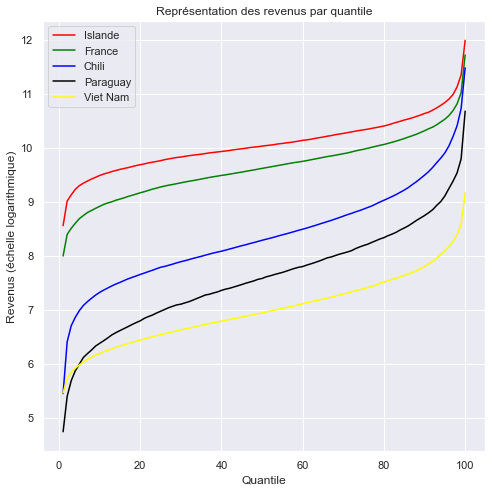

In [46]:

plt.figure(figsize=(7,7))
sns.set(style="darkgrid")
couleur=['red','green','blue','black','yellow']
liste=['Islande','France','Chili','Paraguay','Viet Nam']
for i in range(len(liste)):
    ddl=df.loc[(df['Pays']==liste[i]),:]
    plt.plot(ddl['quantile'],np.log(ddl['income']),
             label=liste[i],color=couleur[i])
plt.title('Représentation des revenus par quantile')    
plt.xlabel('Quantile')
plt.ylabel('Revenus (échelle logarithmique)')    
plt.legend(loc = "upper left")
plt.tight_layout()
# Sauvegarde
plt.savefig("graph representation_revenus.png",dpi=80, format='png', bbox_inches="tight")
plt.show()

La distribution des revenus suit pour chaque pays représenté la même courbe à des échelles différentes.

Pour vérifie l’égalité des répartitions de  revenus moyens on trace les courbes de lorenz

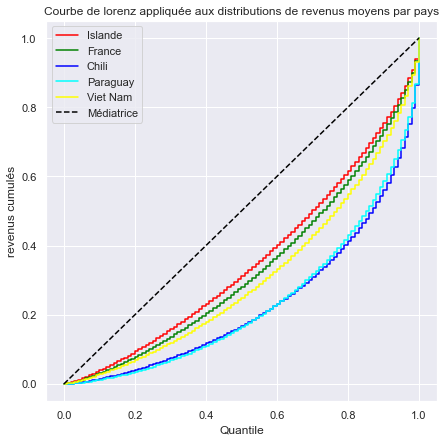

In [47]:
plt.figure(figsize=(7,7))
sns.set(style="darkgrid")
couleur=['red','green','blue','cyan','yellow']

for i in range(len(liste)):
    ddl=df.loc[(df['Pays']==liste[i]),:]
    dep = ddl['income'].values
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
    plt.plot(np.linspace(0,1,len(lorenz)),lorenz,drawstyle='steps-post',
         label=liste[i],color=couleur[i])
x = [0, 1]
y = [0, 1]
plt.plot(x, y, 'black', linestyle='--', label='Médiatrice')
plt.title('Courbe de lorenz appliquée aux distributions de revenus moyens par pays')
plt.xlabel('Quantile')
plt.ylabel('revenus cumulés')
plt.legend()
# Sauvegarde
plt.savefig(" Courbe de lorenz appliquée aux distributions de revenus moyens par pays.png",dpi=80, format='png', bbox_inches="tight")
plt.show()


Les disparités dans la répartition des revenus varient considérablement d'un pays à l'autre.

On trace un graphique qui montre l'évolution des indices de gini de 2004 à 2011

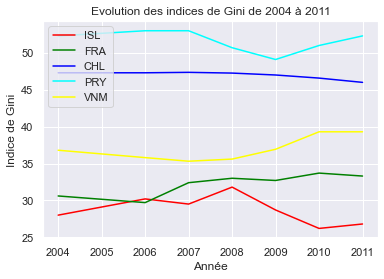

In [48]:
liste1=['ISL','FRA','CHL','PRY','VNM']
ii.loc[ii['country']=='CHL','indice_gini']=ii.loc[ii['country']=='CHL']['indice_gini'].interpolate(method='polynomial', order=2).fillna(method='bfill')
ii.loc[ii['country']=='VNM','indice_gini']=ii.loc[ii['country']=='VNM']['indice_gini'].interpolate(method='polynomial', order=2).fillna(method='ffill')

for i in range(len(liste1)):
    ggl=ii.loc[(ii['country']==liste1[i]),:]
    plt.plot(ggl['year_survey'],ggl['indice_gini'],
             label=liste1[i],color=couleur[i])
plt.title('Evolution des indices de Gini de 2004 à 2011') 
plt.xlabel('Année')
plt.ylabel('Indice de Gini')
plt.legend(loc = "upper left")
# Sauvegarde
plt.savefig("Evolution des indices de Gini.png",dpi=80, format='png', bbox_inches="tight")
plt.show()


Les indices de gini sont relativement stables au cour de la périodes analysée

Les 5 pays avec le plus faible indice de Gini

In [49]:
gini_pays=df.groupby(['Pays','year_survey','country']).mean()
class_gini=gini_pays.sort_values(by=['indice_gini'])
class_gini.head(n=5)

,,,income,gdpppp,population,indice_gini
Pays,year_survey,country,,,,
Slovénie,2008,SVN,12106.007475,27197.0,2021316.0,23.7
Danemark,2008,DNK,17043.146491,34130.0,5493621.0,25.2
Slovaquie,2008,SVK,6096.579894,20515.0,5379233.0,26.0
République tchèque,2008,CZE,8235.293411,23223.0,10384603.0,26.3
Ukraine,2008,UKR,3349.388306,6721.0,46258189.0,26.6


 ces pays sont tout concentré en europe

Les 5 pays avec le plus haut indice de Gini

In [50]:
class_gini.tail(n=5)

,,,income,gdpppp,population,indice_gini
Pays,year_survey,country,,,,
Colombie,2008,COL,3547.005276,8185.0,44254972.0,55.300
Honduras,2008,HND,3296.268419,3628.0,7980955.0,55.500
République centrafricaine,2008,CAF,811.299901,685.0,4273368.0,56.200
Guatemala,2011,GTM,2142.474753,4367.0,14521515.0,56.829
Afrique du Sud,2008,ZAF,5617.904880,9602.0,49779472.0,63.000


ces pays sont situé soit en afrique soit en amérique

le classement de la france par l'indice de gini

In [51]:
class_gini.reset_index(inplace=True)
print(class_gini.loc[class_gini['country']=='FRA',:])

      Pays  year_survey country        income   gdpppp  population  \
38  France         2008     FRA  18309.407545  30357.0  64374979.0   

    indice_gini  
38         33.0  


## Mission03

Pour appliquer la régression linéaire on a besoin l'indice de gini, le revenu moyen et la classe de revenu des parents comme il nous manque la classe de revenu des parent on a décidé de simuler cette information en utilisant le coefficion d'élasticité donc On importe le fichier contenant les coefficients d'élasticité à partir le site de worldbank 

In [52]:
GDIM = pd.DataFrame(pd.read_csv("GDIMMay2018.csv"))
GDIM= GDIM[['countryname', 'iso3', 'region', 'incgroup4', 'year', 'IGEincome']]
GDIM

,countryname,iso3,region,incgroup4,year,IGEincome
0,Afghanistan,AFG,South Asia,Low income,1980,NaN
1,Afghanistan,AFG,South Asia,Low income,1980,NaN
2,Afghanistan,AFG,South Asia,Low income,1980,NaN
3,Afghanistan,AFG,South Asia,Low income,1980,NaN
4,Afghanistan,AFG,South Asia,Low income,1980,NaN
...,...,...,...,...,...,...
6499,Zambia,ZMB,Sub-Saharan Africa,Lower middle income,1980,NaN
6500,Zambia,ZMB,Sub-Saharan Africa,Lower middle income,1980,NaN
6501,Zambia,ZMB,Sub-Saharan Africa,Lower middle income,1980,NaN
6502,Zambia,ZMB,Sub-Saharan Africa,Lower middle income,1980,NaN


In [53]:
GDIM.year.unique()

array([1980, 1940, 1950, 1960, 1970], dtype=int64)

On calcul le coeffcient d'élasticité moyen par pays

In [54]:
elast_reg_an=GDIM.groupby(['iso3','region','incgroup4']).mean().reset_index()
elast_reg_an

,iso3,region,incgroup4,year,IGEincome
0,AFG,South Asia,Low income,1980.000000,NaN
1,AGO,Sub-Saharan Africa,Upper middle income,1980.000000,NaN
2,ALB,Europe & Central Asia,Upper middle income,1960.000000,0.815874
3,ARG,Latin America & Caribbean,Upper middle income,1960.000000,NaN
4,ARM,Europe & Central Asia,Lower middle income,1960.000000,NaN
...,...,...,...,...,...
145,VNM,East Asia & Pacific,Lower middle income,1962.641509,0.480000
146,VUT,East Asia & Pacific,Lower middle income,1980.000000,NaN
147,YEM,Middle East & North Africa,Lower middle income,1980.000000,NaN
148,ZAF,Sub-Saharan Africa,Upper middle income,1960.000000,0.677000


On Calcul des 'IGEincome'  moyen par région et groupe de revenus pour qu'on puisse utiliser le 2 ème fichier pour remplacer les valeurs manquantes

In [55]:
elast_reg=elast_reg_an.groupby(['region','incgroup4']).mean().reset_index()
elast_reg=elast_reg[['region','incgroup4','IGEincome']]
elast_reg

,region,incgroup4,IGEincome
0,East Asia & Pacific,Lower middle income,0.527665
1,East Asia & Pacific,Upper middle income,0.469500
2,Europe & Central Asia,Lower middle income,0.424817
3,Europe & Central Asia,Upper middle income,0.477171
4,High income,High income,0.346163
5,Latin America & Caribbean,Lower middle income,0.940737
6,Latin America & Caribbean,Upper middle income,0.878852
7,Middle East & North Africa,Lower middle income,0.916461
8,Middle East & North Africa,Upper middle income,0.517398
9,South Asia,Low income,0.436000


On remplace les valeurs manquantes en utlisant le 2 ème fichier

In [56]:
elast_reg.loc[elast_reg['IGEincome'].isnull(),'IGEincome']=0.4

On fait la jointure des deux dataframes contenant les coefficients d'élasticité

In [57]:
elast=elast_reg_an.merge(elast_reg,
                            left_on=['region','incgroup4'],
                            right_on=['region','incgroup4'],
                           suffixes=('_1', '_2'))
elast

,iso3,region,incgroup4,year,IGEincome_1,IGEincome_2
0,AFG,South Asia,Low income,1980.0,NaN,0.436000
1,NPL,South Asia,Low income,1960.0,0.436000,0.436000
2,AGO,Sub-Saharan Africa,Upper middle income,1980.0,NaN,0.677000
3,BWA,Sub-Saharan Africa,Upper middle income,1980.0,NaN,0.677000
4,GAB,Sub-Saharan Africa,Upper middle income,1980.0,NaN,0.677000
...,...,...,...,...,...,...
145,IRN,Middle East & North Africa,Upper middle income,1980.0,NaN,0.517398
146,IRQ,Middle East & North Africa,Upper middle income,1960.0,NaN,0.517398
147,JOR,Middle East & North Africa,Upper middle income,1960.0,0.517398,0.517398
148,LBN,Middle East & North Africa,Upper middle income,1980.0,NaN,0.517398


On remplace les valeurs manquantes

In [58]:
elast.loc[elast['IGEincome_1'].isnull(),'IGEincome_1']=elast.loc[elast['IGEincome_1'].isnull(),'IGEincome_2']
elast

,iso3,region,incgroup4,year,IGEincome_1,IGEincome_2
0,AFG,South Asia,Low income,1980.0,0.436000,0.436000
1,NPL,South Asia,Low income,1960.0,0.436000,0.436000
2,AGO,Sub-Saharan Africa,Upper middle income,1980.0,0.677000,0.677000
3,BWA,Sub-Saharan Africa,Upper middle income,1980.0,0.677000,0.677000
4,GAB,Sub-Saharan Africa,Upper middle income,1980.0,0.677000,0.677000
...,...,...,...,...,...,...
145,IRN,Middle East & North Africa,Upper middle income,1980.0,0.517398,0.517398
146,IRQ,Middle East & North Africa,Upper middle income,1960.0,0.517398,0.517398
147,JOR,Middle East & North Africa,Upper middle income,1960.0,0.517398,0.517398
148,LBN,Middle East & North Africa,Upper middle income,1980.0,0.517398,0.517398


on utilise le code de cour pour générer un grand nombre de réalisation des revenus des parents exprimé en logarithme selon la loi normale et pour le même nombre de réalisation générer du terme l'érreur selon la loi normal centré réduite et à partier c'est deux var on calcule le revenu d'enfant et puis on affecte les classes des revenu et on calcul les probabilité conditionnelle

In [59]:
# Génération selon la loi Normale
def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent) # Calcul des revenus des parents et des enfants
# Détermination de la classe de revenus (enfants/parents)    
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)#pour ne pas tomber sur la classe (nb_quantiles+1) et au mm temps de garder le nbr d'échantillon 
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child) # Conversion des tableaux en series
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)# Mise en forme
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

def distribution(counts, nb_quantiles):# On divise le nombre d'individus compté par le nombre d'individus total pour chaque quantile parent
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)# On compte chaque combinaison c_i_child, c_i_parent
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []# Pour chaque quantile enfant, on crée la ligne de distribution du c_i_parent
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

On utilise la fonction generate_incomes pour calculer les revenus des enfants et des parents

In [60]:

pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 100     # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon
y_child, y_parents = generate_incomes(n, pj)
y_child

array([0.39288433, 0.51721321, 0.76575081, ..., 1.68890026, 0.61040991,
       0.19773157])

In [61]:
y_parents

array([0.6040695 , 0.7216114 , 0.54849444, ..., 1.40339122, 1.00145678,
       0.44167096])

on utilise la fonction compute_quantiles pour affecter les classes des revenus(parent, enfant)

In [62]:
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
sample

,y_child,y_parents,c_i_child,c_i_parent
0,0.392884,0.604070,25,31
1,0.517213,0.721611,32,38
2,0.765751,0.548494,43,28
3,4.539716,2.184498,88,79
4,0.169417,0.144328,10,3
...,...,...,...,...
99995,0.081203,0.189180,4,5
99996,0.150710,0.374387,8,17
99997,1.688900,1.403391,66,64
99998,0.610410,1.001457,36,50


On calcul les distributions conditionnelles 

In [63]:
cd = conditional_distributions(sample, nb_quantiles)# Cette instruction prendra du temps si nb_quantiles > 10
print(cd)

[[0.26  0.099 0.101 ... 0.    0.    0.   ]
 [0.127 0.089 0.068 ... 0.    0.    0.   ]
 [0.093 0.065 0.054 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.067 0.069 0.087]
 [0.    0.    0.    ... 0.071 0.111 0.115]
 [0.    0.    0.    ... 0.085 0.121 0.233]]


un exemple de calculer la probabilité conditionnelle en utilisant la matrice de distribution conditionnelle

In [64]:
c_i_child = 5
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))



P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.022


In [65]:
cd[5,8]

0.022

pour vérifie l'impact de coefficient d'élasticité sur la distribution conditionnelle on trace deux graphique sur un satck bars l'un avec pj=0.1 et lautre pj=0.9.

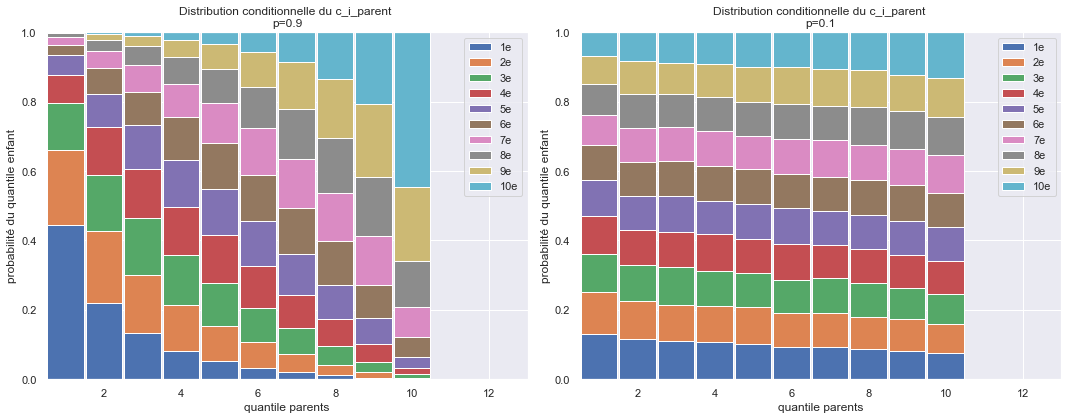

In [66]:
# Graphique pour une faible mobilité
pj=0.9
nb_quantiles=10
y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
p = proba_cond(c_i_parent, c_i_child, cd)
plt.figure(figsize=(15,6))
plt.subplot(121)
# La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
cumul = np.array([0] * nb_quantiles)
    
for i, child_quantile in enumerate(cd):
    plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
    cumul = cumul + np.array(child_quantile)

plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
plt.title("Distribution conditionnelle du c_i_parent \n"+ "p=" + str(pj))
plt.legend()
plt.xlabel("quantile parents")
plt.ylabel("probabilité du quantile enfant")
# Graphique pour une forte mobilité
pj1=0.1
y_child1, y_parents1 = generate_incomes(n, pj1)
sample1 = compute_quantiles(y_child1, y_parents1, nb_quantiles)
cd1 = conditional_distributions(sample1, nb_quantiles)
p = proba_cond(c_i_parent, c_i_child, cd1)
plt.subplot(122)
cumul = np.array([0] * nb_quantiles)
    
for i, child_quantile in enumerate(cd1):
    plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
    cumul = cumul + np.array(child_quantile)
plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
plt.title("Distribution conditionnelle du c_i_parent \n"+ "p=" + str(pj1))
plt.legend()
plt.xlabel("quantile parents")
plt.ylabel("probabilité du quantile enfant")
plt.tight_layout()
plt.savefig('Distribution conditionnelle.png')

Dans le cas où le pj traduisant une forte mobilité, les probabilités des quantiles enfants sont mieux distribuées.

On intègre les coefficients d'élasticité dans notre base de données

In [67]:
dataset=df.merge(elast,how='left', 
                         left_on=['country'], 
                         right_on=['iso3'])
dataset=dataset[['country','Pays','quantile','gdpppp','income','indice_gini','IGEincome_1']]
dataset=dataset.rename({'IGEincome_1':'coeff_elas'},axis=1)
dataset

,country,Pays,quantile,gdpppp,income,indice_gini,coeff_elas
0,ALB,Albanie,1,7297.00000,728.89795,30.0,0.815874
1,ALB,Albanie,2,7297.00000,916.66235,30.0,0.815874
2,ALB,Albanie,3,7297.00000,1010.91600,30.0,0.815874
3,ALB,Albanie,4,7297.00000,1086.90780,30.0,0.815874
4,ALB,Albanie,5,7297.00000,1132.69970,30.0,0.815874
...,...,...,...,...,...,...,...
11595,COD,Congo République démocratique du,96,303.19305,810.62330,44.4,0.707703
11596,COD,Congo République démocratique du,97,303.19305,911.78340,44.4,0.707703
11597,COD,Congo République démocratique du,98,303.19305,1057.80740,44.4,0.707703
11598,COD,Congo République démocratique du,99,303.19305,1286.60290,44.4,0.707703


Après la jointure on vérifie les valeurs manquantes

In [68]:
dataset.loc[dataset['coeff_elas'].isnull(),:]

,country,Pays,quantile,gdpppp,income,indice_gini,coeff_elas
5800,XKX,Kosovo,1,7249.357,437.89370,31.447,NaN
5801,XKX,Kosovo,2,7249.357,508.17133,31.447,NaN
5802,XKX,Kosovo,3,7249.357,591.82820,31.447,NaN
5803,XKX,Kosovo,4,7249.357,668.00000,31.447,NaN
5804,XKX,Kosovo,5,7249.357,730.40220,31.447,NaN
...,...,...,...,...,...,...,...
9995,SYR,République arabe syrienne (Syrie),96,4512.000,1702.83960,35.761,NaN
9996,SYR,République arabe syrienne (Syrie),97,4512.000,1883.93970,35.761,NaN
9997,SYR,République arabe syrienne (Syrie),98,4512.000,2157.02400,35.761,NaN
9998,SYR,République arabe syrienne (Syrie),99,4512.000,2622.62130,35.761,NaN


On suprime les pays concernés par les valeurs manquantes (Syrie et Kosovo)

In [69]:
dataset=dataset.loc[~dataset['coeff_elas'].isnull(),:]


On crée un nouvel échantillon afin de trouver pour chaque classe de revenu de chaque pays 500 individus

In [70]:
ddf = pd.concat([dataset]*500, ignore_index=True)
ddf=ddf.sort_values(by=['country','quantile']).reset_index()
ddf=ddf.rename({'income':'y_child'},axis=1)
ddf=ddf.rename({'quantile':'c_i_child'},axis=1)
ddf

,index,country,Pays,c_i_child,gdpppp,y_child,indice_gini,coeff_elas
0,0,ALB,Albanie,1,7297.0,728.89795,30.0,0.815874
1,11400,ALB,Albanie,1,7297.0,728.89795,30.0,0.815874
2,22800,ALB,Albanie,1,7297.0,728.89795,30.0,0.815874
3,34200,ALB,Albanie,1,7297.0,728.89795,30.0,0.815874
4,45600,ALB,Albanie,1,7297.0,728.89795,30.0,0.815874
...,...,...,...,...,...,...,...,...
5699995,5654299,ZAF,Afrique du Sud,100,9602.0,82408.55000,63.0,0.677000
5699996,5665699,ZAF,Afrique du Sud,100,9602.0,82408.55000,63.0,0.677000
5699997,5677099,ZAF,Afrique du Sud,100,9602.0,82408.55000,63.0,0.677000
5699998,5688499,ZAF,Afrique du Sud,100,9602.0,82408.55000,63.0,0.677000


On affecte la classe des revenus de parents en fonctionde la classe des revenus des enfants et les coefficients d'élasticité conformément aux distributions conditionnelle calculé précédemment 

In [71]:
t_start=dt.now()
pays=ddf['country'].unique()
list_c=[]
for i in pays:
    pj=ddf.loc[ddf['country']==i,'coeff_elas'].iloc[0]
    nb_quantiles = 100 # nombre de quantiles (nombre de classes de revenu)
    n = 500*nb_quantiles # taille de l'échantillon
    y_child, y_parents = generate_incomes(n, pj)
    sample = compute_quantiles(y_child, y_parents, nb_quantiles)
    cd = conditional_distributions(sample, nb_quantiles)
    for c_i_child in range(100):
        for c_i_parent in range(100):
            p = proba_cond(c_i_parent, c_i_child, cd)
            # On étend la liste list_c de l'index + 1 de la valeur contenu en c_i_child, c_i_parent
            list_c.extend([c_i_parent+1]*(int(p*500)))
t_end=dt.now()
t_total=t_end-t_start
print(t_total)    

0:14:30.412824


On affecte les valeurs de la liste list_c à la colonne c_i_parents de notre dataframe principale  

In [72]:
ddf["c_i_parents"]=list_c

In [73]:
ddf.head(3)

,index,country,Pays,c_i_child,gdpppp,y_child,indice_gini,coeff_elas,c_i_parents
0,0,ALB,Albanie,1,7297.0,728.89795,30.0,0.815874,1
1,11400,ALB,Albanie,1,7297.0,728.89795,30.0,0.815874,1
2,22800,ALB,Albanie,1,7297.0,728.89795,30.0,0.815874,1


On Supprime la variable c_i_child inutile pour la mission 4

In [74]:
ddf.drop(columns='c_i_child', inplace=True)
ddf.drop(columns='index', inplace=True)

Création d'un dataframe avec la variable revenu moyen du pays

In [75]:
revenu_moy = ddf.groupby(by='Pays').mean()
revenu_moy.reset_index(inplace=True)
revenu_moy = revenu_moy[['Pays', 'y_child']]
revenu_moy.rename(columns={'y_child': 'mj'}, inplace=True)
revenu_moy.head(3)

,Pays,mj
0,Afrique du Sud,5617.904880
1,Albanie,2994.829902
2,Allemagne,18061.718142


On rajoute de la colonne revenu_moy

In [76]:
ddf = pd.merge(ddf, revenu_moy, on='Pays')
ddf.head(3)

,country,Pays,gdpppp,y_child,indice_gini,coeff_elas,c_i_parents,mj
0,ALB,Albanie,7297.0,728.89795,30.0,0.815874,1,2994.829902
1,ALB,Albanie,7297.0,728.89795,30.0,0.815874,1,2994.829902
2,ALB,Albanie,7297.0,728.89795,30.0,0.815874,1,2994.829902


On rajoute les colonnes des revenus en 'logarithmes'

In [77]:
ddf['ln_y_child'] = np.log(ddf['y_child'])
ddf['ln_mj'] = np.log(ddf['mj'])
ddf.head(3)

,country,Pays,gdpppp,y_child,indice_gini,coeff_elas,c_i_parents,mj,ln_y_child,ln_mj
0,ALB,Albanie,7297.0,728.89795,30.0,0.815874,1,2994.829902,6.591534,8.004643
1,ALB,Albanie,7297.0,728.89795,30.0,0.815874,1,2994.829902,6.591534,8.004643
2,ALB,Albanie,7297.0,728.89795,30.0,0.815874,1,2994.829902,6.591534,8.004643


Enregistrement du fichier

In [78]:
ddf.to_csv('dataframe7.csv', index=False)